In [1]:
from image.segmentation import BasicImageSegmenter
from ml.eval import eval_model
from ml.pipeline import FeitDataPipeline

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules

from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow import keras

from cfg import *

from livelossplot import PlotLossesKerasTF

import os
print(os.getcwd())
os.chdir('/home/jelinek/recetox/')


model_name = 'ResNet50_ImagenetWeightsTrainLast-256'

2022-02-15 09:11:09.902248: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-15 09:11:12.247885: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-02-15 09:11:12.248209: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-02-15 09:11:12.257656: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-15 09:11:12.326587: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2022-02-15 09:11:12.326946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-02-15 09:11:12.337187: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2022-02-

/home/jelinek/recetox/src/notebooks


In [2]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


class MyResNet50(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params. name = model_name
        self.params.batch_size = 16
        self.params.tile_size = 256

        lr_schedule = schedules.ExponentialDecay(
                        initial_learning_rate=1e-1,
                        decay_steps=80,
                        decay_rate=0.1,
                        staircase=True)

        self.optimizer = ( Adam(
            learning_rate=lr_schedule,
            beta_1=0.99,
            beta_2=0.9999))

    # def get_data_loader_training(self):
    #     datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
    #                                        samplewise_std_normalization=True, height_shift_range=0.25, width_shift_range=0.25,
    #                                        zoom_range=0.25, rotation_range=30)
    #
    #     return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
    #                                          class_mode='categorical', batch_size=self.params.batch_size,
    #                                          shuffle=True,
    #                                          target_size=(self.params.tile_size, self.params.tile_size))
    #
    # def get_data_loader_validation(self):
    #     datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
    #     return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
    #                                              class_mode='categorical', batch_size=self.params.batch_size,
    #                                              shuffle=False,
    #                                              target_size=(self.params.tile_size, self.params.tile_size))

    def get_datagen_segmentation(self):
        return ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)


    @staticmethod
    def get_compiled_model():
        base_model = ResNet50(include_top=False,
                      input_shape=(256, 256, 3),
                      weights='imagenet',
                      pooling=None
                      )
        base_model.trainable = False

        inputs = keras.Input(shape=(256, 256, 3))
        x = base_model(inputs, training=False)
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        outputs = keras.layers.Dense(12, activation='softmax', name='probs')(x)

        model = keras.Model(inputs, outputs)

        return model

    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=100,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=5,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

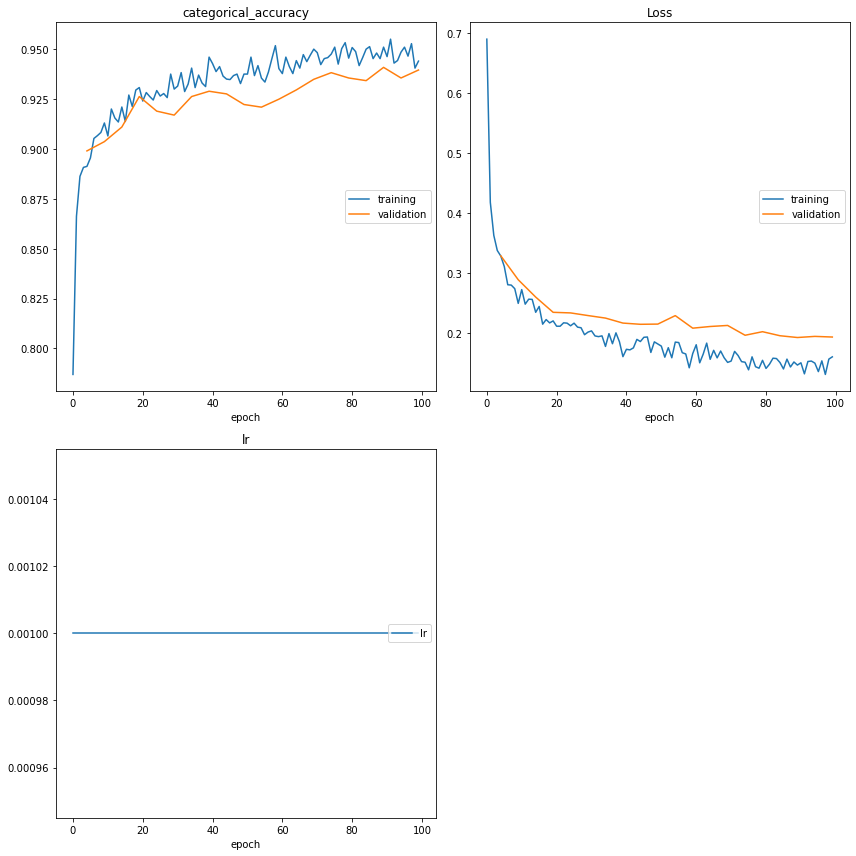

categorical_accuracy
	training         	 (min:    0.787, max:    0.955, cur:    0.944)
	validation       	 (min:    0.899, max:    0.941, cur:    0.940)
Loss
	training         	 (min:    0.132, max:    0.690, cur:    0.161)
	validation       	 (min:    0.193, max:    0.329, cur:    0.194)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
95/95 [==============================] - 5s 51ms/step - loss: 0.1941 - categorical_accuracy: 0.9395
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 1.0711ms
Confusion Matrix
[[319   1   3   0   2   0   0   0   0   0   9   1]
 [  4  46   8   1   1   0   1   1   0   0   2   0]
 [  1   5 134   0   1   0   2   2   0   0   0   0]
 [  0   1   0  10   0   0   0   0   0   0   0   0]
 [  1   0   0   1 542   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   5   0   0   0  70   1   0   0   0   0]
 [  0   0   6   0   0   0   0  79   0   0   1   0]
 [  0   0   0   0   0   0   0   0   1   

In [3]:
pipeline = MyResNet50(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                      valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [4]:
pipeline.save_pipeline()

/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [5]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           print_confusion_matrix=True,
           save_misclassified=False)

Found 1505 images belonging to 12 classes.
95/95 [==============================] - 5s 51ms/step - loss: 0.1941 - categorical_accuracy: 0.9395
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.9700ms
Confusion Matrix
[[319   1   3   0   2   0   0   0   0   0   9   1]
 [  4  46   8   1   1   0   1   1   0   0   2   0]
 [  1   5 134   0   1   0   2   2   0   0   0   0]
 [  0   1   0  10   0   0   0   0   0   0   0   0]
 [  1   0   0   1 542   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   5   0   0   0  70   1   0   0   0   0]
 [  0   0   6   0   0   0   0  79   0   0   1   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0]
 [ 20   1   1   0   1   0   1   1   0   0 209   0]
 [  0   0   0   0   0   0   0   0   0   0   2   4]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.92      0.95      0.94 

In [2]:
pipeline = FeitDataPipeline.load_pipeline(model_name)


2022-02-15 09:11:21.841584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 09:11:21.841779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-15 09:11:21.841831: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-15 09:11:21.874577: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-15 09:11:21.874696: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-02-15 09:11:21.910703: I tensorflow/stream_exec

In [3]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / model_name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=0)

Processing region 1 out of 120

2022-02-15 09:11:25.497143: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-15 09:11:25.519895: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3399905000 Hz
2022-02-15 09:11:26.297346: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-02-15 09:11:27.212525: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-02-15 09:11:28.493434: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-15 09:11:28.493463: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-02-15 09:11:28.494113: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-02-15 09:11:28.494178: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

Processing region 120 out of 120
Processing image took 2578.2305524349213 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-256/ns-adenoca-colon-15071-2019-20x-he-4.tiff
Processing region 255 out of 255
Processing image took 6190.350555419922 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-256/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
Processing region 255 out of 255
Processing image took 6056.839920759201 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-256/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
Processing region 56 out of 56
Processing image took 1234.1840586662292 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-256/ns-adenoca-colon-lupos-15071-2019-20x-he-14.tiff
Processing region 567 out of 567
Processing image took 14199.804604291916 seconds
Saving file...
File saved to segmentations/ResNet50_ImagenetWeightsTrainLast-256/pop-ca-colon-